In [1]:
# --- 0. Import Library yang Diperlukan ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 
from sklearn.metrics import classification_report, confusion_matrix

# Pastikan stop_words NLTK sudah diunduh. Jalankan ini sekali saja.
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
    print("NLTK stopwords for 'indonesian' downloaded.")

In [2]:
# --- 1. Load Data dan Preprocessing Awal ---
print("--- Bagian 1: Pemuatan Data dan Preprocessing Awal ---")
file_path = "Data.csv" # Ganti nama file jika berbeda
df = pd.read_csv(file_path)

# Drop baris kosong pada kolom 'sentiment' untuk memastikan data bersih
df = df.dropna(subset=["sentiment"])

# Konversi kolom 'sentiment' ke integer (jika belum)
df['sentiment'] = df['sentiment'].astype(int)

# Mapping label angka ke teks
label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
df['sentiment_label'] = df['sentiment'].map(label_map)

# Cetak distribusi sentimen untuk analisis awal
print("\nDistribusi Sentimen dalam Dataset:")
print(df['sentiment_label'].value_counts())
print("-" * 50)

--- Bagian 1: Pemuatan Data dan Preprocessing Awal ---

Distribusi Sentimen dalam Dataset:
sentiment_label
positif    1026
negatif     621
netral      546
Name: count, dtype: int64
--------------------------------------------------


In [3]:
# --- 2. Fungsi Preprocessing Teks ---
print("\n--- Bagian 2: Preprocessing Teks ---")

def preprocess_text(text):
    """
    Fungsi untuk membersihkan teks ulasan.
    Melakukan:
    - Konversi ke huruf kecil.
    - Menghapus URL.
    - Menghapus mention (@username).
    - Menghapus hashtag (#hashtag).
    - Menghapus angka.
    - Menghapus tanda baca (kecuali apostrof).
    - Menghapus kata-kata pendek (1 karakter).
    - Menghapus spasi ganda dan trim.
    """
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"@\w+", "", text)     
    text = re.sub(r"#\w+", "", text)     
    text = re.sub(r"\d+", "", text)      
    # Menghilangkan tanda baca, kecuali apostrof
    text = text.translate(str.maketrans('', '', string.punctuation.replace("'", "")))

    # Hapus kata-kata yang terlalu pendek dan tidak bermakna
    text = ' '.join(word for word in text.split() if len(word) > 1)

    # Menghapus spasi ganda dan trim
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Terapkan preprocessing ke kolom 'review_text'
df["clean_text"] = df["review_text"].apply(preprocess_text)

# Tampilkan 5 data pertama setelah preprocessing
print("\nData setelah preprocessing:")
print(df[["review_text", "clean_text", "sentiment_label"]].head())
print("-" * 50)



--- Bagian 2: Preprocessing Teks ---

Data setelah preprocessing:
                                         review_text  \
0  Materinya goks abis, auto paham! Instrukturnya...   
1  Platformnya anjay, interaktif banget, jadi gak...   
2  Mentornya pro player, ngajarnya santuy tapi ng...   
3  Sumpah, ini kursus paling oke! Ilmunya kepake ...   
4  Sertifikatnya nampol buat naikin CV. Vibes bel...   

                                          clean_text sentiment_label  
0  materinya goks abis auto paham instrukturnya j...         positif  
1  platformnya anjay interaktif banget jadi gak m...         positif  
2  mentornya pro player ngajarnya santuy tapi nge...         positif  
3  sumpah ini kursus paling oke ilmunya kepake ba...         positif  
4  sertifikatnya nampol buat naikin cv vibes bela...         positif  
--------------------------------------------------


In [4]:
# --- 3. Split Data Pelatihan dan Pengujian ---
print("\n--- Bagian 3: Pembagian Data ---")
# Fitur (X) dan label (y)
X = df["clean_text"]
y = df["sentiment_label"]

# Split data: 80% latih, 20% uji
# random_state digunakan agar hasil split konsisten setiap kali dijalankan
# stratify=y penting untuk memastikan distribusi kelas sentimen yang sama di train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran Data Latih (X_train): {X_train.shape[0]} samples")
print(f"Ukuran Data Uji (X_test): {X_test.shape[0]} samples")
print("-" * 50)


--- Bagian 3: Pembagian Data ---
Ukuran Data Latih (X_train): 1754 samples
Ukuran Data Uji (X_test): 439 samples
--------------------------------------------------


In [5]:
# --- 4. TF-IDF Vektorisasi Teks ---
print("\n--- Bagian 4: TF-IDF Vektorisasi Teks ---")
# Inisialisasi TfidfVectorizer
# max_features: Batasi jumlah fitur (kata) yang digunakan
# ngram_range: Pertimbangkan unigram dan bigram (pasangan kata)
stop_words_id = set(stopwords.words('indonesian'))

tfidf = TfidfVectorizer(max_features=5000,
                        ngram_range=(1, 2), # Bisa coba (1,3) atau (2,2) jika diperlukan
                        stop_words=list(stop_words_id) # Tambahkan stop_words bahasa Indonesia
                       )

# Fit TF-IDF hanya pada data pelatihan, lalu transform data pelatihan
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform data pengujian menggunakan vektorizer yang sudah di-fit dari data pelatihan
# Ini MENCEGAH DATA LEAKAGE dari data uji ke data latih
X_test_tfidf = tfidf.transform(X_test)

print(f"Ukuran Matriks TF-IDF Data Latih: {X_train_tfidf.shape}")
print(f"Ukuran Matriks TF-IDF Data Uji: {X_test_tfidf.shape}")
print("-" * 50)



--- Bagian 4: TF-IDF Vektorisasi Teks ---
Ukuran Matriks TF-IDF Data Latih: (1754, 1246)
Ukuran Matriks TF-IDF Data Uji: (439, 1246)
--------------------------------------------------


c:\Users\202ak\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [6]:
# --- 5. Pelatihan Model Logistic Regression ---
print("\n--- Bagian 5: Pelatihan Model Logistic Regression ---")
# Buat dan latih model Logistic Regression
# class_weight='balanced' penting untuk menangani ketidakseimbangan kelas (jika ada)
# solver='liblinear' cocok untuk dataset kecil-menengah dan bekerja baik dengan L1/L2 regularization
model_lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, class_weight='balanced')
model_lr.fit(X_train_tfidf, y_train)

print("Model Logistic Regression telah dilatih.")
print("-" * 50)


--- Bagian 5: Pelatihan Model Logistic Regression ---
Model Logistic Regression telah dilatih.
--------------------------------------------------



--- Bagian 6: Evaluasi Model Logistic Regression ---

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       124
      netral       1.00      1.00      1.00       109
     positif       1.00      1.00      1.00       206

    accuracy                           1.00       439
   macro avg       1.00      1.00      1.00       439
weighted avg       1.00      1.00      1.00       439



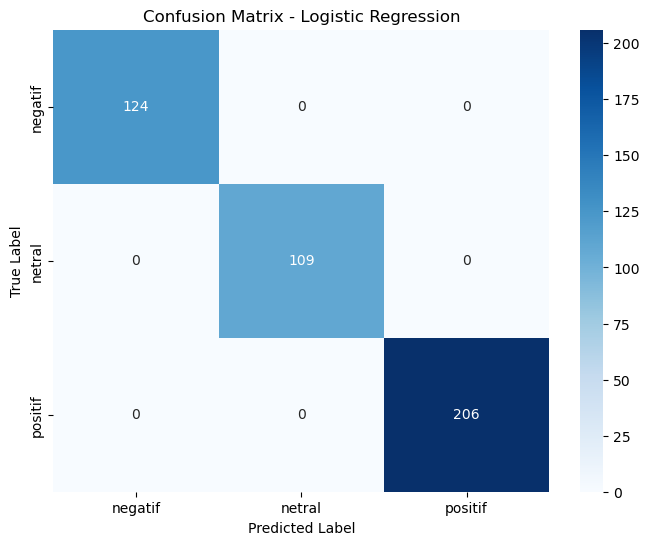

--------------------------------------------------


In [7]:
# --- 6. Evaluasi Model Logistic Regression ---
print("\n--- Bagian 6: Evaluasi Model Logistic Regression ---")
# Prediksi hasil uji
y_pred_lr = model_lr.predict(X_test_tfidf)

# Evaluasi performa model
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, zero_division=0)) # zero_division=0 untuk menghindari warning jika ada kelas tanpa prediksi/true samples

# Confusion matrix
labels = sorted(df['sentiment_label'].unique()) # Pastikan urutan label konsisten
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)

# Plot heatmap confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()
print("-" * 50)

In [8]:
# --- 7. Contoh Prediksi Baru (Logistic Regression) ---
print("\n--- Bagian 7: Contoh Prediksi Baru (Logistic Regression) ---")
new_reviews = [
    "Materinya goks abis, auto paham! Instrukturnya juga asik banget.", 
    "Platformnya anjay, interaktif banget, jadi gak bosen.", 
    "Mentornya pro player, ngajarnya santuy tapi ngegas materinya.", 
    "Sumpah, ini kursus paling oke! Ilmunya kepake banget.", 
    "Sertifikatnya nampol buat naikin CV. Vibes belajarnya mantul.", 
    "Pelayanan customer service nya sangat buruk, bikin emosi.", 
    "Gak ada tugas praktek, jadi cuma teori doang. Kurang mantep", 
    "Kurang memuaskan, kecewa dengan layanannya.", 
    "Produk ini sangat bagus dan sesuai harapan!", 
    "Biasa saja, tidak ada yang spesial.",
    "Gampang dipake, efektif banget. Hasilnya pecah!"
]

# Preprocess ulasan baru
clean_new_reviews = [preprocess_text(review) for review in new_reviews]

# Vektorisasi ulasan baru menggunakan TF-IDF yang sudah di-fit dari data pelatihan
new_reviews_tfidf = tfidf.transform(clean_new_reviews)

# Prediksi sentimen
predictions_lr = model_lr.predict(new_reviews_tfidf)

print("\nHasil Prediksi dengan Logistic Regression:")
for i, review in enumerate(new_reviews):
    print(f"Ulasan: '{review}' -> Sentimen: {predictions_lr[i]}")
print("-" * 50)


--- Bagian 7: Contoh Prediksi Baru (Logistic Regression) ---

Hasil Prediksi dengan Logistic Regression:
Ulasan: 'Materinya goks abis, auto paham! Instrukturnya juga asik banget.' -> Sentimen: positif
Ulasan: 'Platformnya anjay, interaktif banget, jadi gak bosen.' -> Sentimen: positif
Ulasan: 'Mentornya pro player, ngajarnya santuy tapi ngegas materinya.' -> Sentimen: positif
Ulasan: 'Sumpah, ini kursus paling oke! Ilmunya kepake banget.' -> Sentimen: positif
Ulasan: 'Sertifikatnya nampol buat naikin CV. Vibes belajarnya mantul.' -> Sentimen: positif
Ulasan: 'Pelayanan customer service nya sangat buruk, bikin emosi.' -> Sentimen: negatif
Ulasan: 'Gak ada tugas praktek, jadi cuma teori doang. Kurang mantep' -> Sentimen: negatif
Ulasan: 'Kurang memuaskan, kecewa dengan layanannya.' -> Sentimen: negatif
Ulasan: 'Produk ini sangat bagus dan sesuai harapan!' -> Sentimen: netral
Ulasan: 'Biasa saja, tidak ada yang spesial.' -> Sentimen: netral
Ulasan: 'Gampang dipake, efektif banget. Hasiln


--- Bagian 8: Pelatihan dan Evaluasi Model LinearSVC ---
Model LinearSVC telah dilatih.

Classification Report (LinearSVC):
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       124
      netral       1.00      1.00      1.00       109
     positif       1.00      1.00      1.00       206

    accuracy                           1.00       439
   macro avg       1.00      1.00      1.00       439
weighted avg       1.00      1.00      1.00       439



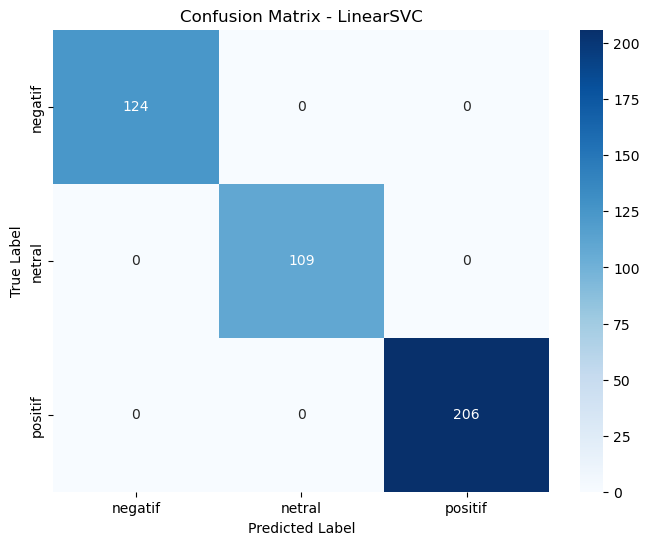

--------------------------------------------------


In [9]:
# --- 8. Pelatihan dan Evaluasi Model LinearSVC (Alternatif/Perbandingan) ---
print("\n--- Bagian 8: Pelatihan dan Evaluasi Model LinearSVC ---")
# Model SVM (LinearSVC adalah implementasi SVM yang cocok untuk data teks)
# class_weight='balanced' juga bisa diterapkan di sini
model_svc = LinearSVC(random_state=42, class_weight='balanced', max_iter=1000)
model_svc.fit(X_train_tfidf, y_train)

print("Model LinearSVC telah dilatih.")

# Evaluasi
y_pred_svc = model_svc.predict(X_test_tfidf)
print("\nClassification Report (LinearSVC):")
print(classification_report(y_test, y_pred_svc, zero_division=0))

# Confusion Matrix
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=labels) # Menggunakan labels yang sama
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LinearSVC")
plt.show()
print("-" * 50)